In [ ]:
#! pip install --index-url https://test.pypi.org/simple/ PyARMViz

In [1]:
# OS
import os

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from stop_words import get_stop_words
#library for regular expressions
import re 
import string
# Activate CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Maths
import math
#time
import time

#Graficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import networkx as nx

# Arules Plot
from PyARMViz import PyARMViz
# warnigs
import warnings

warnings.filterwarnings('ignore')

In [2]:
%run D:/ACADEMY/ANALYTICS/SCRIPTS/Python/MachineLearning/HelpFunctions/HelpStatFunctions.ipynb

Loading TicTacFunctions...
Loading describeBasic...
Loading describeNans...
Loading describeUniques...
Loading describeCommons...
Loading describeAllMetrics...
Loading corrStack...
Loading corrFeatureFilter...


In [3]:
#Estableciendo el directorio de trabajo
os.chdir(r"D:/ACADEMY/ANALYTICS/SCRIPTS/Python/TextAnalysis")

In [11]:
fileName='Reclamos_SUR_sample.csv'
data = pd.read_csv(fileName,delimiter=';')[['NUMERO_RECLAMO','OBS_RECLAMO']]
data.head(2)

,NUMERO_RECLAMO,OBS_RECLAMO
0,2816,Valentín Alvarez entre Calderón de la Barca y ...
1,2818,Basural fuera contenedor calle Virrey Elio y B...


In [12]:
# Make Column to STRING
data.OBS_RECLAMO=data.OBS_RECLAMO.astype(str)

In [13]:
print('--------------- data ---------------')
data.shape

--------------- data ---------------


(73886, 2)

In [14]:
fixLetters={'Š':'S', 'š':'s', 'Ž':'Z', 'ž':'z', 'À':'A', 'Á':'A', 'Â':'A', 'Ã':'A', 'Ä':'A', 'Å':'A', 'Æ':'A', 'Ç':'C', 'È':'E', 'É':'E',
                          'Ê':'E', 'Ë':'E', 'Ì':'I', 'Í':'I', 'Î':'I', 'Ï':'I', 'Ñ':'Ni',  'Ò':'O', 'Ó':'O', 'Ô':'O', 'Õ':'O', 'Ö':'O', 'Ø':'O', 'Ù':'U',
                          'Ú':'U', 'Û':'U', 'Ü':'U', 'Ý':'Y', 'Þ':'B', 'ß':'Ss', 'à':'a', 'á':'a', 'â':'a', 'ã':'a', 'ä':'a', 'å':'a', 'æ':'a', 'ç':'c',
                          'è':'e', 'é':'e', 'ê':'e', 'ë':'e', 'ì':'i', 'í':'i', 'î':'i', 'ï':'i', 'ð':'o', 'ñ':'ni', 'ò':'o', 'ó':'o', 'ô':'o', 'õ':'o',
                          'ö':'o', 'ø':'o', 'ù':'u', 'ú':'u', 'û':'u', 'ý':'y', 'ý':'y', 'þ':'b', 'ÿ':'y'}

In [15]:
# Function to clean Text
def cleanTxt(txt)-> str:
    final_string = ""
    #remove hyperlinks
    txt= re.sub(r'https?:\/\/\S+','',txt)
    #Make lower
    txt = txt.lower()
    # Remove line breaks
    txt = re.sub(r'\n', '', txt)
    ### Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    txt = txt.translate(translator)
    # Remove stop words
    txt = txt.split()
    useless_words = get_stop_words('spanish')
    text_filtered = [word for word in txt if not word in useless_words]
    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
    
    final_string = ' '.join(text_filtered)
    return final_string

In [16]:
tic()
# Clean TXT : tolower-breaks-punctuation
data['OBS_RECLAMO_CLEAN']      = data['OBS_RECLAMO'].apply(cleanTxt)
# Replace specific characters
for old, new in fixLetters.items():
        data['OBS_RECLAMO_CLEAN'] = data['OBS_RECLAMO_CLEAN'].str.replace(old, new, regex=False) 
#
tac()
data[['OBS_RECLAMO','OBS_RECLAMO_CLEAN']] .head()

Time elapsed: 0hour:0min:3sec


,OBS_RECLAMO,OBS_RECLAMO_CLEAN
0,Valentín Alvarez entre Calderón de la Barca y ...,valentin alvarez calderon barca yegros
1,Basural fuera contenedor calle Virrey Elio y B...,basural contenedor calle virrey elio besares
2,A pesar de que en el barrio existen esquinas m...,pesar barrio existen esquinas amplias paviment...
3,Sofa cama averiado,sofa cama averiado
4,Problema de Alumbrado Publico,problema alumbrado publico


In [17]:
# Make a List of words with low frecuency
tic()
# Sparse Matrix
vectMt            = CountVectorizer()  
vectsMt           = vectMt.fit_transform(data.OBS_RECLAMO_CLEAN)
# Doc Matrix 
tdMt              = pd.DataFrame(vectsMt.todense()).iloc[:len(data)]
tdMt.columns      = vectMt.get_feature_names_out()
# Frecuency Table
tdFreq            = tdMt.sum(axis=0).to_frame().reset_index()
tdFreq.rename(columns = {'index':'word',0:'freq'}, inplace = True)
# Threshold Minimum freq per word
thresholdWordFreq = math.floor(math.log(len(tdFreq)))
wordsWithLowFreq  = tdFreq[tdFreq["freq"] <= thresholdWordFreq]['word'].to_list()
wordsWithLowFreq
tac()
print('.....Show first words.....')
tdFreq

Time elapsed: 0hour:0min:3sec
.....Show first words.....


,word,freq
0,aa,6
1,aaa,1
2,aag,1
3,aarbol,1
4,aarboles,1
...,...,...
24250,zuniiga,16
24251,zunino,1
24252,zurich,3
24253,üapagado,1


In [18]:
print('--------------- Column DF to extend frase ---------------')
tic()
comment_words = ''
# iterate through the csv file
for val in data.OBS_RECLAMO_CLEAN:
	# typecaste each val to string
	val = str(val)
    #Remove Extra Spaces
	val = re.sub(' +', ' ', val)
	# split the value
	tokens = val.split(' ')
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	comment_words += " ".join(tokens)+" "
tac()

--------------- Column DF to extend frase ---------------
Time elapsed: 0hour:0min:1sec


In [19]:
# Make a Extend list to remove
stop_words_sp = get_stop_words('spanish')
#stop_words_sp=stop_words_sp+wordsWithLowFreq

In [20]:
len(stop_words_sp)

308

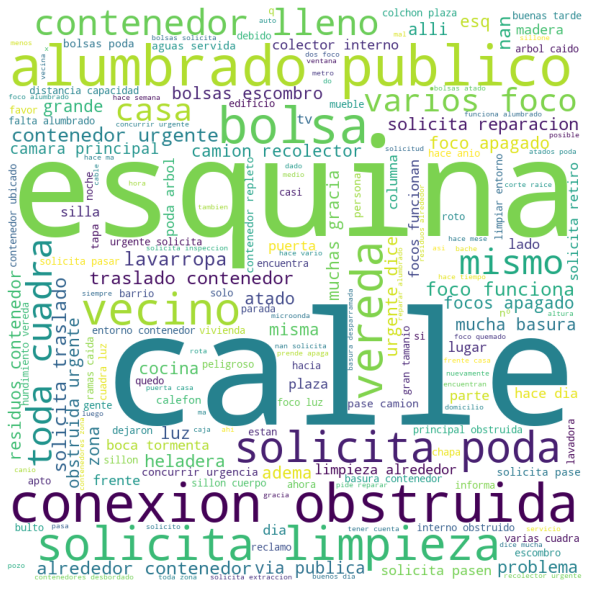

In [21]:
wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stop_words_sp,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
wordcloud.to_file('wordcloud.png') # guardar wordcloud
plt.show()

In [22]:
tdFreqDict = {}
for a, x in tdFreq.values:
    tdFreqDict[a] = x
#    

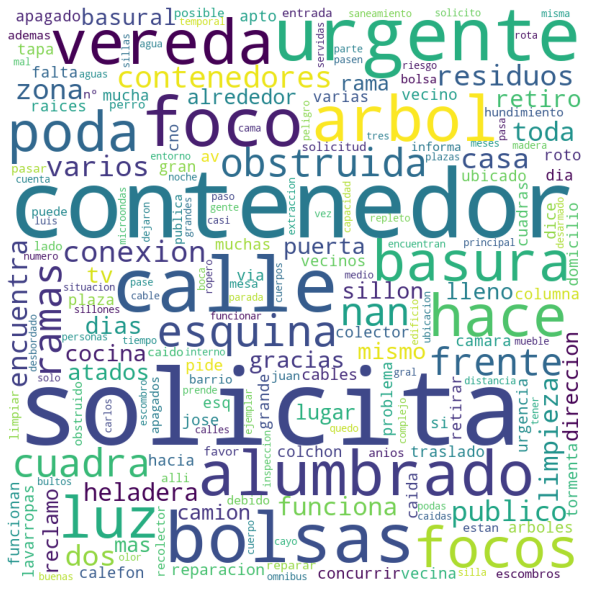

In [23]:
wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stop_words_sp,
				min_font_size = 10).generate_from_frequencies(tdFreqDict)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
wordcloud.to_file('wordcloud.png') # guardar wordcloud
plt.show()

In [24]:
tic()
# Sparse Matrix
vect                 = CountVectorizer()  
vects                = vect.fit_transform(data.OBS_RECLAMO_CLEAN)
# Doc Matrix 
td                   = pd.DataFrame(vects.todense()).iloc[:len(data)]
td.columns           = vect.get_feature_names_out()
td.index             = ['Doc_'+str(i) for i in range(1, len(data)+1)]
# Remove columns with low Freq
wordsSelected        = [column for column in td.columns if column not in wordsWithLowFreq]
term_document_matrix = td[wordsSelected]
tac()

Time elapsed: 0hour:0min:9sec


In [25]:
term_document_matrix.head(10)

,abajo,abalos,abandonada,abandonado,abarca,abasto,abayuba,abejas,abierta,abierto,...,zola,zona,zonal,zonas,zorrilla,zubillaga,zubiria,zudaniez,zum,zuniiga
Doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Doc_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Doc_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
tic()
# Frecuency Table
term_document_freq                  = term_document_matrix.sum(axis=0).to_frame().reset_index()
term_document_freq.rename(columns = {'index':'word',0:'freq'}, inplace = True)
term_document_freq                  = term_document_freq[term_document_freq["freq"] >1000] #Filter freq at least 1000
term_document_total                 = term_document_freq['freq'].sum()
term_document_freq['percentage']    = term_document_freq['freq']/term_document_total*100
term_document_freq                  = term_document_freq.sort_values(by=['freq'],ascending=False)
term_document_freq.reset_index(inplace=True,drop=True)
term_document_freq['cum_percentage']= term_document_freq['percentage'].cumsum()
tac()
term_document_freq

Time elapsed: 0hour:0min:0sec


,word,freq,percentage,cum_percentage
0,solicita,11327,6.341431,6.341431
1,contenedor,10580,5.923222,12.264653
2,calle,6272,3.511385,15.776037
3,urgente,5899,3.302560,19.078597
4,bolsas,5190,2.905626,21.984223
...,...,...,...,...
76,colector,1036,0.580005,97.718608
77,camara,1025,0.573847,98.292455
78,grande,1021,0.571608,98.864063
79,columna,1020,0.571048,99.435110


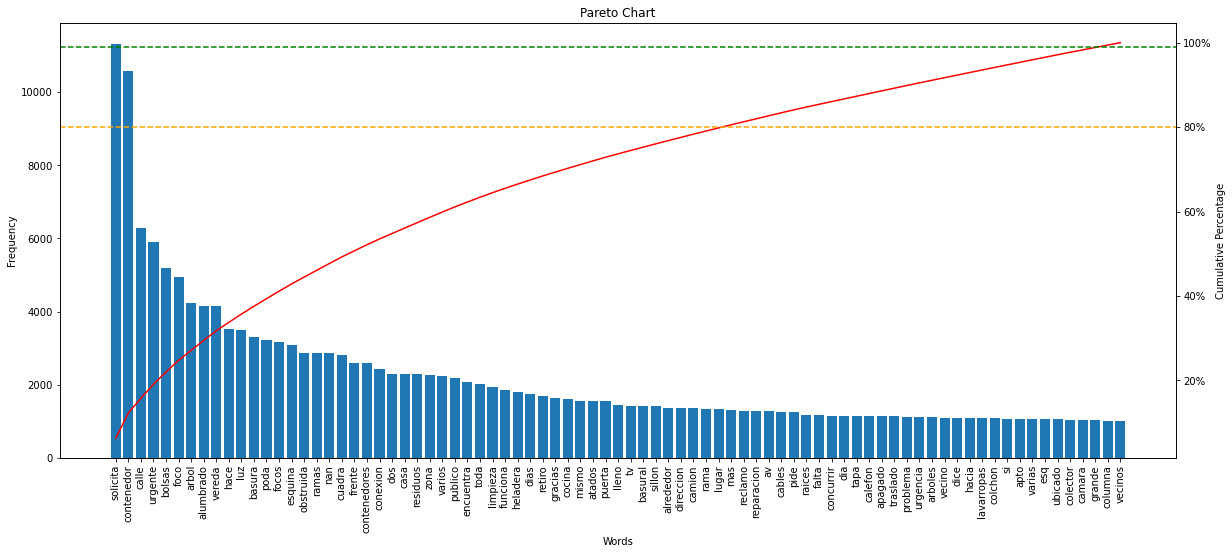

In [27]:
# Set figure and axis
fig, ax = plt.subplots(figsize=(20,8))

# Plot bars (i.e. frequencies)
ax.bar(term_document_freq["word"], term_document_freq["freq"])
ax.set_title("Pareto Chart")
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
plt.xticks(rotation=90)

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
ax2.plot(term_document_freq["word"], term_document_freq["cum_percentage"], color="red", ms=7)  # marker="D"
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.axhline(99, color="green", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

In [28]:
tic()
def encodeOnesZeros(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
# Make Binary table
term_document_matrix_sets = term_document_matrix.applymap(encodeOnesZeros)
tac()

Time elapsed: 0hour:0min:57sec


In [29]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [30]:
tic()
frequent_itemsets = apriori(term_document_matrix_sets.astype('bool'), min_support=0.005, use_colnames=True)
tac()

Time elapsed: 0hour:0min:5sec


In [31]:
apriori_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
apriori_rules#.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(servidas),(aguas),0.006321,0.007254,0.006199,0.980728,135.190434,0.006153,51.512465
1,(aguas),(servidas),0.007254,0.006321,0.006199,0.854478,135.190434,0.006153,6.828361
2,(basura),(alrededor),0.038965,0.018150,0.007606,0.195207,10.755436,0.006899,1.220003
3,(alrededor),(basura),0.018150,0.038965,0.007606,0.419090,10.755436,0.006899,1.654361
4,(contenedor),(alrededor),0.125599,0.018150,0.014739,0.117349,6.465666,0.012459,1.112388
...,...,...,...,...,...,...,...,...,...
679,(contenedor),"(urgente, limpieza, alrededor, solicita)",0.125599,0.005766,0.005563,0.044289,7.681506,0.004838,1.040308
680,(alrededor),"(contenedor, urgente, limpieza, solicita)",0.018150,0.009054,0.005563,0.306488,33.849252,0.005398,1.428879
681,(solicita),"(contenedor, urgente, limpieza, alrededor)",0.149663,0.005590,0.005563,0.037168,6.649322,0.004726,1.032797
682,(urgente),"(contenedor, limpieza, alrededor, solicita)",0.078729,0.008730,0.005563,0.070655,8.093665,0.004875,1.066633


In [32]:
rules=apriori_rules.copy()
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules=rules[rules["lift"] > 10]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,servidas,aguas,0.006321,0.007254,0.006199,0.980728,135.190434,0.006153,51.512465
1,aguas,servidas,0.007254,0.006321,0.006199,0.854478,135.190434,0.006153,6.828361
2,basura,alrededor,0.038965,0.018150,0.007606,0.195207,10.755436,0.006899,1.220003
3,alrededor,basura,0.018150,0.038965,0.007606,0.419090,10.755436,0.006899,1.654361
6,limpieza,alrededor,0.025458,0.018150,0.010259,0.402977,22.203109,0.009797,1.644578
...,...,...,...,...,...,...,...,...,...
676,urgente,contenedor,0.039574,0.009217,0.005563,0.140561,15.250339,0.005198,1.152825
677,limpieza,contenedor,0.019462,0.005820,0.005563,0.285814,49.110758,0.005449,1.392046
678,urgente,contenedor,0.011518,0.009339,0.005563,0.482961,51.716048,0.005455,1.916029
680,alrededor,contenedor,0.018150,0.009054,0.005563,0.306488,33.849252,0.005398,1.428879


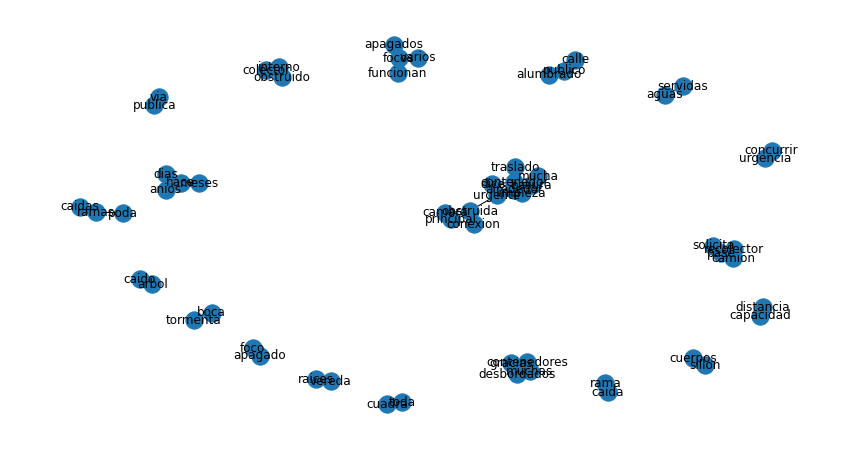

In [33]:
fig, ax=plt.subplots(figsize=(15,8))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

In [34]:
aprioriRulesMtx                 = apriori_rules.copy()
aprioriRulesMtx['lhs_items']    = aprioriRulesMtx['antecedents'].apply(lambda x:len(x) )
aprioriRulesMtx[aprioriRulesMtx['lhs_items']>1].sort_values('lift', ascending=False).head()
aprioriRulesMtx['antecedents_'] = aprioriRulesMtx['antecedents'].apply(lambda a: ','.join(list(a)))
aprioriRulesMtx['consequents_'] = aprioriRulesMtx['consequents'].apply(lambda a: ','.join(list(a)))
aprioriRulesMtx

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs_items,antecedents_,consequents_
0,(servidas),(aguas),0.006321,0.007254,0.006199,0.980728,135.190434,0.006153,51.512465,1,servidas,aguas
1,(aguas),(servidas),0.007254,0.006321,0.006199,0.854478,135.190434,0.006153,6.828361,1,aguas,servidas
2,(basura),(alrededor),0.038965,0.018150,0.007606,0.195207,10.755436,0.006899,1.220003,1,basura,alrededor
3,(alrededor),(basura),0.018150,0.038965,0.007606,0.419090,10.755436,0.006899,1.654361,1,alrededor,basura
4,(contenedor),(alrededor),0.125599,0.018150,0.014739,0.117349,6.465666,0.012459,1.112388,1,contenedor,alrededor
...,...,...,...,...,...,...,...,...,...,...,...,...
679,(contenedor),"(urgente, limpieza, alrededor, solicita)",0.125599,0.005766,0.005563,0.044289,7.681506,0.004838,1.040308,1,contenedor,"urgente,limpieza,alrededor,solicita"
680,(alrededor),"(contenedor, urgente, limpieza, solicita)",0.018150,0.009054,0.005563,0.306488,33.849252,0.005398,1.428879,1,alrededor,"contenedor,urgente,limpieza,solicita"
681,(solicita),"(contenedor, urgente, limpieza, alrededor)",0.149663,0.005590,0.005563,0.037168,6.649322,0.004726,1.032797,1,solicita,"contenedor,urgente,limpieza,alrededor"
682,(urgente),"(contenedor, limpieza, alrededor, solicita)",0.078729,0.008730,0.005563,0.070655,8.093665,0.004875,1.066633,1,urgente,"contenedor,limpieza,alrededor,solicita"


In [35]:
antc =aprioriRulesMtx[['antecedents_']]
antc.rename(columns = {'antecedents_':'itemSets'}, inplace = True)
consc=aprioriRulesMtx[['consequents_']]
consc.rename(columns= {'consequents_':'itemSets'}, inplace = True)

itemSets=antc.append(consc).drop_duplicates(keep='last')
itemSets.reset_index(inplace=True,drop=True)
itemSets.reset_index(inplace=True)
itemSets['index']=itemSets['index'].astype(str)
itemSets

,index,itemSets
0,0,aguas
1,1,servidas
2,2,falta
3,3,reparar
4,4,anios
...,...,...
168,168,"urgente,limpieza,alrededor,solicita"
169,169,"contenedor,urgente,limpieza,solicita"
170,170,"contenedor,urgente,limpieza,alrededor"
171,171,"contenedor,limpieza,alrededor,solicita"


In [36]:
itemSetsDict = {}
for a, x in itemSets.values:
    itemSetsDict[x] = a
#

In [37]:
aprioriRulesMtx['antecedents_key'] = aprioriRulesMtx['antecedents_'].map(itemSetsDict)
aprioriRulesMtx['consequents_key'] = aprioriRulesMtx['consequents_'].map(itemSetsDict)
aprioriRulesMtx['keyOrder']        = aprioriRulesMtx['antecedents_key']+','+aprioriRulesMtx['consequents_key']
aprioriRulesMtx['keyOrder']        = aprioriRulesMtx['keyOrder'].apply(lambda x: sorted(list(map(int, x.split(','))))).astype(str)
aprioriRulesMtx.sort_values(by=['keyOrder','confidence'], inplace=True,ascending = [False, False])
aprioriRulesMtx.drop_duplicates(subset=['keyOrder'], keep='first',inplace=True)
aprioriRulesMtx.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs_items,antecedents_,consequents_,antecedents_key,consequents_key,keyOrder
498,(traslado),"(contenedor, solicita)",0.014780,0.046274,0.010692,0.723443,15.633906,0.010008,3.448572,1,traslado,"contenedor,solicita",99,156,"[99, 156]"
191,(traslado),(contenedor),0.014780,0.125599,0.012641,0.855311,6.809864,0.010785,6.043329,1,traslado,contenedor,99,147,"[99, 147]"
312,(traslado),(solicita),0.014780,0.149663,0.012316,0.833333,5.568065,0.010104,5.102022,1,traslado,solicita,99,145,"[99, 145]"
476,"(contenedor, encuentra)",(solicita),0.008066,0.149663,0.005008,0.620805,4.148022,0.003800,2.242482,2,"contenedor,encuentra",solicita,98,145,"[98, 145]"
478,"(encuentra, solicita)",(contenedor),0.012222,0.125599,0.005008,0.409745,3.262332,0.003473,1.481396,2,"encuentra,solicita",contenedor,97,147,"[97, 147]"
480,(encuentra),"(contenedor, solicita)",0.026216,0.046274,0.005008,0.191017,4.127957,0.003795,1.178920,1,encuentra,"contenedor,solicita",96,156,"[96, 156]"
161,(encuentra),(contenedor),0.026216,0.125599,0.008066,0.307692,2.449801,0.004774,1.263024,1,encuentra,contenedor,96,147,"[96, 147]"
222,(encuentra),(solicita),0.026216,0.149663,0.012222,0.466185,3.114897,0.008298,1.592943,1,encuentra,solicita,96,145,"[96, 145]"
459,"(obstruida, conexion)",(urgente),0.025215,0.078729,0.008148,0.323135,4.104372,0.006163,1.361084,2,"obstruida,conexion",urgente,94,144,"[94, 144]"
460,"(urgente, conexion)",(obstruida),0.008824,0.038735,0.008148,0.923313,23.836442,0.007806,12.534891,2,"urgente,conexion",obstruida,93,92,"[92, 93]"


In [38]:
pivot                           = aprioriRulesMtx[aprioriRulesMtx['lift']>50].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
pivot=(pivot/100).round(2)
pivot

consequents_,aguas,"alrededor,solicita",camara,camion,colector,"contenedor,limpieza","contenedor,limpieza,solicita",distancia,obstruido,"obstruido,colector",pase,principal,recolector,"recolector,camion","recolector,solicita","solicita,camion",tormenta,"urgente,limpieza",via
antecedents_,,,,,,,,,,,,,,,,,,,
"alrededor,solicita",NaN,NaN,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.77,NaN,NaN
capacidad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"contenedor,alrededor,solicita",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.52,NaN
"contenedor,urgente,limpieza",NaN,0.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interno,NaN,NaN,NaN,NaN,0.70,NaN,NaN,NaN,0.88,1.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"interno,colector",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"interno,obstruido",NaN,NaN,NaN,NaN,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"obstruida,camara",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN


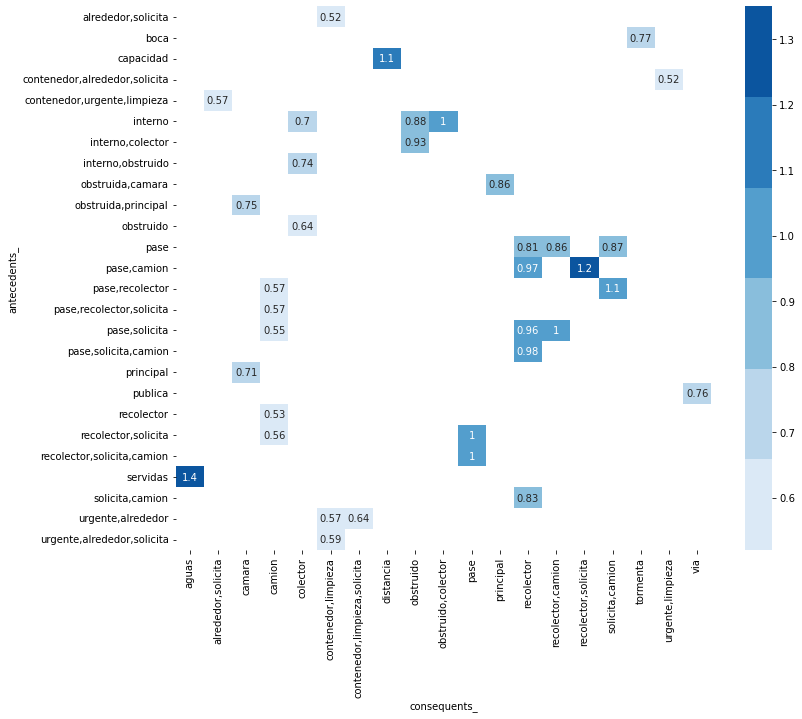

In [39]:
plt.figure(figsize = (12,10))

colormap = sns.color_palette("Blues")

sns.heatmap(pivot, cmap=colormap,annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

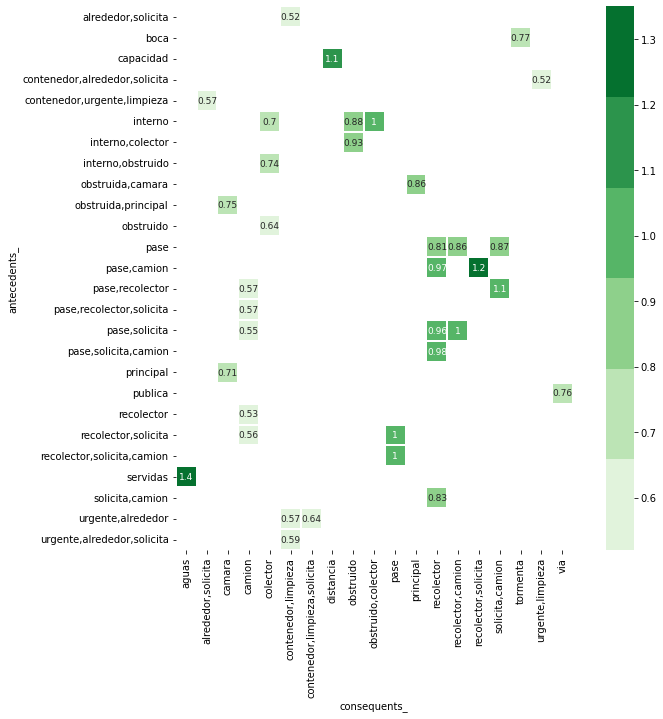

In [40]:
plt.figure(figsize = (12,10))
colormap = sns.color_palette("Greens")
sns.heatmap(pivot, 
            cmap=colormap, linewidths=0.1,
            annot=True, annot_kws={"size": 9}, square=True);

In [ ]:

tic()

# determining the name of the file
file_name = 'apriori_rules.xlsx'
  
# saving the excel
apriori_rules.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')
tac()


In [ ]:

##apriori_rules.sort_values('confidence', ascending = False, inplace = True)
##
##apriori_vis = apriori_rules
##
##apriori_vis['uni'] = np.nan
##apriori_vis['ant'] = np.nan
##apriori_vis['con'] = np.nan
##apriori_vis['tot'] = 20507
##
##transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]
##
##def tran():
##    for t in transactions:
##        yield t
##def antec(x):
##    cnt = 0
##    for t in tran():
##        t = set(t)
##        if x.intersection(t) == x:
##            cnt = cnt + 1
##    return cnt
##vis = apriori_vis.values.tolist()
##
##rules_dict = []
##for i in vis:
##    i[10] = antec(i[0])
##    i[11] = antec(i[1])
##    i[9] = antec(i[0].union(i[1]))
##    diction = {
##        'lhs': tuple(i[0]), 
##        'rhs': tuple(i[1]),
##        'count_full': i[9],
##        'count_lhs': i[10],
##        'count_rhs': i[11],
##        'num_transactions': i[12]
##    }
##    rules_dict.append(diction)
##    
##rules = []
##for rd in rules_dict:
##    rules.append(generate_rule_from_dict(rd))

In [ ]:
##PyARMViz.generate_rule_graph_plotly(rules)

In [ ]:
numbers_string = "699465,699664, 699466, 608462, 608503"
numbers_list = list(map(int,numbers_string.split(',')))
print(numbers_list)

In [ ]:
numbers_array = sorted(numbers_list,key=lambda x: -x)
print(numbers_array)

In [ ]:
vects

In [ ]:
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(comment_words)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
#Display DF 
word_freqDf=pd.DataFrame([word_freq]).T
word_freqDf

In [ ]:
#dictionary consisting of the contraction and the actual value
Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}
 
#replace the contractions
for key,value in Apos_dict.items():
    if key in tweet:
        tweet=tweet.replace(key,value)
 
print("After Contraction replacement the tweet is:-\n{}".format(tweet))

In [ ]:
# Function to clean Text
def replaceSpecialTxt(txt,dictionary)-> str:
    for key,value in dictionary.items():
        if key in txt:
            txt=txt.replace(key,value)